<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# What GPU do we have ?
! nvidia-smi

Thu Sep  3 21:31:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
# install dependencies
! pip install pytorch-lightning wandb
! pip install git+https://github.com/albumentations-team/albumentations

In [4]:
# unzip the data 
!tar xf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/ 

In [ ]:
# Clone the RetinaNet Repo:
# ! git clone https://github.com/benihime91/pytorch_retinanet.git

In [4]:
import os
os.chdir('/content/pytorch_retinanet/')
import warnings
warnings.filterwarnings('ignore')

# use wandb to track experiments
import wandb
wandb.login('a74f67fd5fae293e301ea8b6710ee0241f595a63')

True

In [5]:
! git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/benihime91/pytorch_retinanet
   81be2cd..eda59ae  master     -> origin/master
Updating 81be2cd..eda59ae
Fast-forward
 src/config.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [6]:
from typing import *
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateLogger,
)

from src.models import Retinanet
from src.utils.eval_utils import CocoEvaluator
from src.utils.eval_utils import get_coco_api_from_dataset
from src.utils.general_utils import Visualizer, xml_to_csv
from src.utils.general_utils import collate_fn

pl.seed_everything(42)
pd.set_option("display.max_colwidth", None)

In [7]:
annot_dir = '/content/oxford-iiit-pet/annotations/xmls' # folder where the annotations are stored
img_dir = '/content/oxford-iiit-pet/images' # folder where the training Images are stored

# Create pandas DataFrame from the xmls
df = xml_to_csv(annot_dir)
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Egyptian_Mau_136.jpg,246,280,cat,52,21,212,175
1,Birman_172.jpg,500,375,cat,237,2,392,150
2,english_cocker_spaniel_116.jpg,500,375,dog,102,136,313,317
3,japanese_chin_157.jpg,500,375,dog,99,68,269,218
4,Maine_Coon_127.jpg,500,334,cat,161,38,275,148


In [8]:
# regex to extrac the class names from the filenames of the csv file
pat = r"/([^/]+)_\d+.jpg$"
pat = re.compile(pat)


def get_classes(df=pd.DataFrame) -> pd.DataFrame:
    "creates labels for the Images from given filenames"
    # Extract the label
    df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]
    return df


def preprare_data(
    img_dir: str, data: Union[str, pd.DataFrame]
) -> Union[pd.DataFrame, LabelEncoder]:
    "preprocess the given data and returns a pandas dataframe"
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data
    # modify filename to point to the image path
    df["filename"] = [os.path.join(img_dir, idx) for idx in df.filename.values]
    # get labels from the filename
    df = get_classes(df)
    # encode the labels: convert labels to integers
    le = LabelEncoder()
    int_cls = le.fit(df["class"].unique())
    df["labels"] = le.transform(df["class"])
    return df, le


def create_label_dict(dataframe: pd.DataFrame, encoder: LabelEncoder) -> Dict[int, str]:
    "Creates a label dictionary from the given dataframe `labels`"
    names = list(dataframe.labels.unique())
    names.sort()
    # Create the label dictionary
    label_dict = {
        idx: clas for idx, clas in zip(names, list(encoder.inverse_transform(names)))
    }
    return label_dict

In [9]:
df , le = preprare_data(img_dir, df)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/oxford-iiit-pet/images/Egyptian_Mau_136.jpg,246,280,egyptian_mau,52,21,212,175,11
1,/content/oxford-iiit-pet/images/Birman_172.jpg,500,375,birman,237,2,392,150,6
2,/content/oxford-iiit-pet/images/english_cocker_spaniel_116.jpg,500,375,english_cocker_spaniel,102,136,313,317,12
3,/content/oxford-iiit-pet/images/japanese_chin_157.jpg,500,375,japanese_chin,99,68,269,218,17
4,/content/oxford-iiit-pet/images/Maine_Coon_127.jpg,500,334,maine_coon,161,38,275,148,20


In [10]:
# Grab the label dictionary
label_dict = create_label_dict(df, le)
print(label_dict)

{0: 'abyssinian', 1: 'american_bulldog', 2: 'american_pit_bull_terrier', 3: 'basset_hound', 4: 'beagle', 5: 'bengal', 6: 'birman', 7: 'bombay', 8: 'boxer', 9: 'british_shorthair', 10: 'chihuahua', 11: 'egyptian_mau', 12: 'english_cocker_spaniel', 13: 'english_setter', 14: 'german_shorthaired', 15: 'great_pyrenees', 16: 'havanese', 17: 'japanese_chin', 18: 'keeshond', 19: 'leonberger', 20: 'maine_coon', 21: 'miniature_pinscher', 22: 'newfoundland', 23: 'persian', 24: 'pomeranian', 25: 'pug', 26: 'ragdoll', 27: 'russian_blue', 28: 'saint_bernard', 29: 'samoyed', 30: 'scottish_terrier', 31: 'shiba_inu', 32: 'siamese', 33: 'sphynx', 34: 'staffordshire_bull_terrier', 35: 'wheaten_terrier', 36: 'yorkshire_terrier'}


In [11]:
# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

In [12]:
def display_random_image(dataframe: pd.DataFrame) -> None:
    "displays a radom Image from given dataframe"
    n = np.random.randint(0, len(dataframe))
    fname = df["filename"][n]
    boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
    labels = df.loc[df["filename"] == fname]["labels"].values
    viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10, 10))

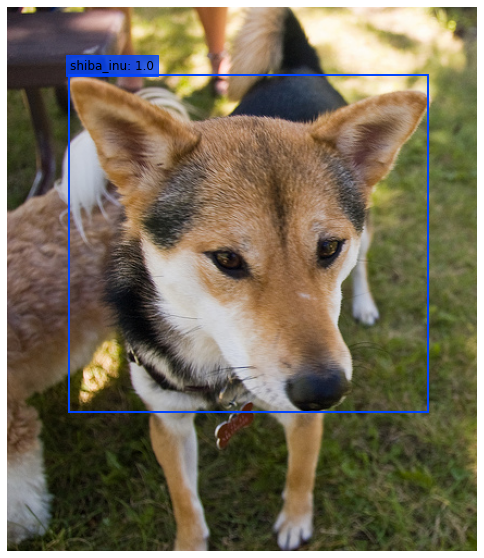

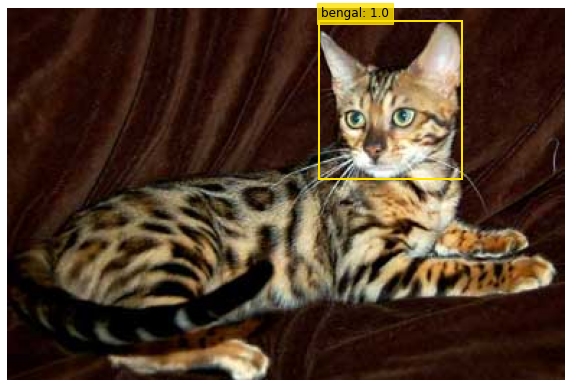

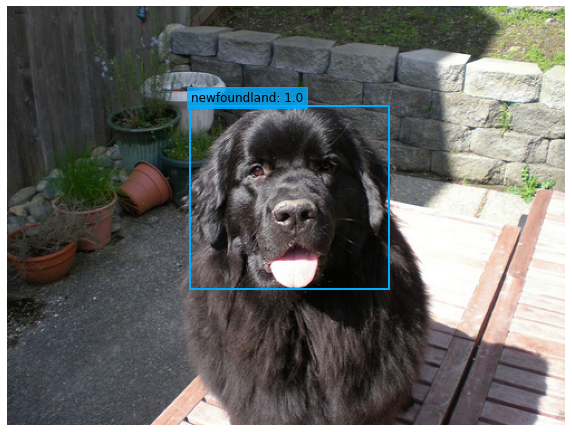

In [43]:
# Display some random Images from the Dataset for sanity check
display_random_image(df)
display_random_image(df)
display_random_image(df)

In [13]:
def create_splits(
    df: pd.DataFrame, split_sz: float = 0.3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    "Split given DataFrame into `split_sz`"
    # Grab the Unique Image Idxs from the Filename
    unique_ids = list(df.filename.unique())
    # Split the Unique Image Idxs into Train & valid Datasets
    train_ids, val_ids = train_test_split(
        unique_ids, shuffle=True, random_state=42, test_size=split_sz
    )

    # Create Splits on the DataFrame
    df["split"] = 0

    for i, idx in enumerate(df.filename.values):
        if idx in set(train_ids):
            df["split"][i] = "train"
        elif idx in set(val_ids):
            df["split"][i] = "val"

    # Split the DataFrame into Train and Valid DataFrames
    df_trn, df_val = df.loc[df["split"] == "train"], df.loc[df["split"] == "val"]
    df_trn, df_val = df_trn.reset_index(drop=True), df_val.reset_index(drop=True)

    # drop the extra redundent column
    df_trn.drop(columns=["split"], inplace=True)
    df_val.drop(columns=["split"], inplace=True)

    return df_trn, df_val

In [14]:
# Create train and validation splits from the dataframe
df_trn, df_val = create_splits(df, split_sz=0.2)
df_val, df_test = create_splits(df_val, split_sz=0.5)

print('Num examples in train dataset', len(df_trn.filename.unique()))
print('Num examples in train dataset', len(df_val.filename.unique()))
print('Num examples in train dataset', len(df_test.filename.unique()))

Num examples in train dataset 2948
Num examples in train dataset 369
Num examples in train dataset 369


In [15]:
# Peek at the train dataset for sanity check
df_trn.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/oxford-iiit-pet/images/Birman_172.jpg,500,375,birman,237,2,392,150,6
1,/content/oxford-iiit-pet/images/english_cocker_spaniel_116.jpg,500,375,english_cocker_spaniel,102,136,313,317,12
2,/content/oxford-iiit-pet/images/japanese_chin_157.jpg,500,375,japanese_chin,99,68,269,218,17
3,/content/oxford-iiit-pet/images/Maine_Coon_127.jpg,500,334,maine_coon,161,38,275,148,20
4,/content/oxford-iiit-pet/images/shiba_inu_163.jpg,500,375,shiba_inu,166,11,271,144,31


In [16]:
# Peek at the validation dataset for sanity check
df_val.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/oxford-iiit-pet/images/shiba_inu_109.jpg,375,500,shiba_inu,169,126,264,229,31
1,/content/oxford-iiit-pet/images/Russian_Blue_181.jpg,500,332,russian_blue,111,6,287,176,27
2,/content/oxford-iiit-pet/images/beagle_172.jpg,500,375,beagle,191,54,390,257,4
3,/content/oxford-iiit-pet/images/Sphynx_110.jpg,376,500,sphynx,33,33,291,301,33
4,/content/oxford-iiit-pet/images/pomeranian_161.jpg,300,200,pomeranian,86,4,209,148,24


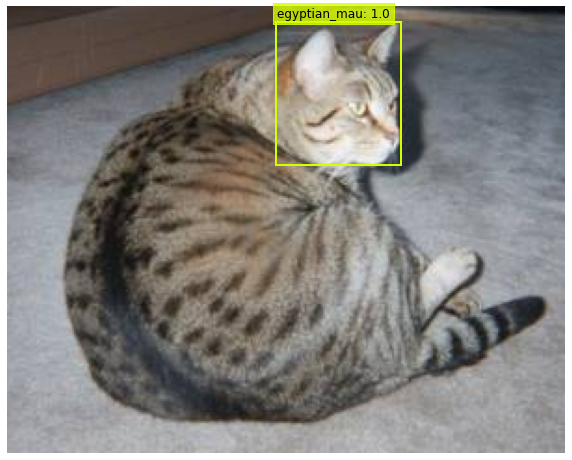

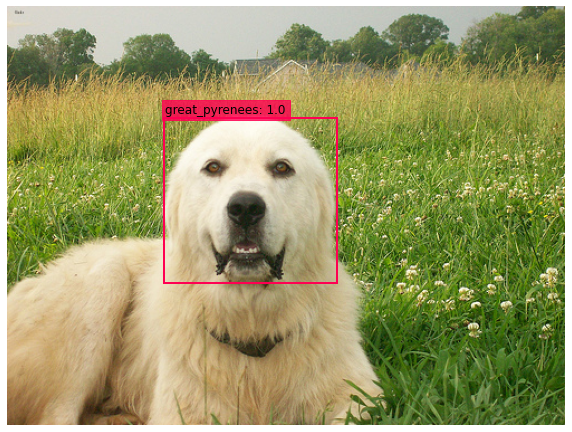

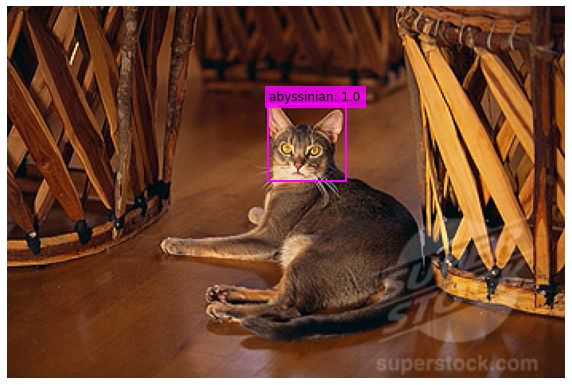

In [48]:
# display random image from the train, valid 
# & test datasets for sanity check
display_random_image(dataframe=df_trn)
display_random_image(dataframe=df_val)
display_random_image(dataframe=df_test)

In [17]:
def get_tfms() -> Dict[str, A.Compose]:
    "Returns a dictionary contatining transformations for train & valid/test datasets"
    # train transformations :
    train_transformations = [
        A.HorizontalFlip(p=0.5),
        A.ToGray(p=0.2),
        A.RandomBrightnessContrast(),
        A.CLAHE(),
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # validation transformations :
    valid_transformations = [
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # transforms dictionary :
    transforms = {
        "train": A.Compose(
            train_transformations,
            p=1.0,
            bbox_params=A.BboxParams(
                format="pascal_voc", label_fields=["class_labels"]
            ),
        ),
        "valid": A.Compose(
            valid_transformations,
            p=1.0,
            bbox_params=A.BboxParams(
                format="pascal_voc", label_fields=["class_labels"]
            ),
        ),
    }
    return transforms

In [18]:
# Create torch.utils.data.Dataset instance for Oxford-IIIT pets Dataset
class PetDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, train:bool):
        # Grab the transforms Dictionary
        tfms = get_tfms()
        
        self.df = dataframe
        self.image_ids = self.df["filename"]
        
        if train:
            self.tfms = tfms["train"]
        else:
            self.tfms = tfms["valid"]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Grab the Image
        image_id = self.image_ids[idx]
        im = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)
        
        # extract the bounding boxes
        records = self.df[self.df["filename"] == image_id]
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        
        # claculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # Grab the Class Labels
        class_labels = records["labels"].values.tolist()
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        # apply transformations
        transformed = self.tfms(image=im, bboxes=boxes, class_labels=class_labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
        class_labels = torch.tensor(transformed["class_labels"])
        
        # target dictionary
        target = {}
        image_idx = torch.tensor([idx])
        target["image_id"] = image_idx
        target["boxes"]    = boxes
        target["labels"]   = class_labels
        target["area"]     = area
        target["iscrowd"]  = iscrowd
        
        return image, target, image_idx

In [19]:
# Create pl.LightningModule instance
class DetectionModel(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        train_dl: torch.utils.data.DataLoader,
        val_dl: torch.utils.data.DataLoader,
        test_dl: torch.utils.data.DataLoader,
        learning_rate: float,
    ):

        super(DetectionModel, self).__init__()
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.test_dl = test_dl
        self.learning_rate = learning_rate
        self.iou_types = ["bbox"]

        # Scheduler parameters
        self.lr_steps = [16, 22]
        self.lr_gamma = 0.1
        self.warmup_iters = min(1000, len(train_dl) - 1)
        self.warmup_factor = 1.0 / 1000

    def configure_optimizers(self, *args, **kwargs):
        "instatiate optimizer & scheduler(s)"
        params = [p for p in self.model.parameters() if p.requires_grad]
        # Optimizer
        self.optimizer = optim.AdamW(
            params, lr=(self.learning_rate or self.lr), weight_decay=1e-03
        )
        # Scheduler for Lr Warm-up
        self.warm_up_scheduler = self.warmup_lr_scheduler(
            self.optimizer, self.warmup_iters, self.warmup_factor
        )
        # StepLrScheduler
        self.scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                self.optimizer, milestones=self.lr_steps, gamma=self.lr_gamma
            ),
            "interval": "epoch",
            "frequency": 1,
        }
        return [self.optimizer], [self.scheduler]

    def warmup_lr_scheduler(self, optimizer, warmup_iters, warmup_factor):
        "lr_scheduler to increase the learning_rate during initial stages"
        def f(x):
            if x >= warmup_iters:
                return 1
            alpha = float(x) / warmup_iters
            return warmup_factor * (1 - alpha) + alpha

        return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

    def optimizer_step(self, current_epoch, batch_nb, optimizer, *args, **kwargs):
        # warm up lr
        if self.trainer.global_step <= self.warmup_iters:
            # update params
            optimizer.step()
            optimizer.zero_grad()
            self.warm_up_scheduler.step()
        else:
            optimizer.step()
            optimizer.zero_grad()

    ############# Train ##############
    def train_dataloader(self, *args, **kwargs):
        return self.train_dl

    def forward(self, xb, *args, **kwargs):
        return self.model(xb)

    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    ############# Validation ##############
    def val_dataloader(self, *args, **kwargs):
        loader = self.val_dl
        coco = get_coco_api_from_dataset(loader.dataset)
        self.coco_evaluator = CocoEvaluator(coco, self.iou_types)
        return loader

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {
            target["image_id"].item(): output
            for target, output in zip(targets, outputs)
        }
        self.coco_evaluator.update(res)
        return {}


    def validation_epoch_end(self, outputs, *args, **kwargs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"COCO_mAP": metric}

        return {
            "val_loss": metric,
            "log": logs,
            "progress_bar": logs,
        }
    
    ############# Test ##############
    def test_dataloader(self, *args, **kwargs):
        loader = self.test_dl
        coco = get_coco_api_from_dataset(loader.dataset)
        self.test_evaluator = CocoEvaluator(coco, self.iou_types)
        return loader

    def test_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {
            target["image_id"].item(): output
            for target, output in zip(targets, outputs)
        }
        self.test_evaluator.update(res)
        return {}
    
    def test_epoch_end(self, outputs, *args, **kwargs):
        self.test_evaluator.accumulate()
        self.test_evaluator.summarize()
        metric = self.test_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"COCO_mAP": metric}

        return {
            "val_loss": metric,
            "log": logs,
            "progress_bar": logs,
        }

In [20]:
# ------------------------------- #
# Training Parameters :
# ------------------------------- #
TRAIN_BATCH_SIZE = 32 # Batch size for train dataset
VALID_BATCH_SIZE = 32 # batch size for valid & test dataset
LR = 1e-04 # learning_rate for SGD Optimizer
NUM_CLASSES = 37  # Oxford-IIIT Pets Dataset has 37 classes

In [21]:
def get_model(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    df_test: pd.DataFrame,
    bkb: str = "resnet34",
    trn_bs: int = TRAIN_BATCH_SIZE,
    val_bs: int = VALID_BATCH_SIZE,
    nc: int = NUM_CLASSES,
    lr: float = LR,
    **kwargs
) -> pl.LightningModule:

    "Returns a Lightning Module instance"
    model = Retinanet(num_classes=nc, backbone_kind=bkb, pretrained=True, **kwargs)

    train_dl = DataLoader(
        PetDataset(df_train, train=True),
        batch_size=trn_bs,
        shuffle=True,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    val_dl = DataLoader(
        PetDataset(df_val, train=False),
        batch_size=val_bs,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    test_dl = DataLoader(
        PetDataset(df_test, train=False),
        batch_size=val_bs,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    model = DetectionModel(model, train_dl, val_dl, test_dl, learning_rate=LR,)
    return model


def get_trainer(
    epochs: int = 25, filepath: str = "/content/drive/My Drive/checkpoints", **kwargs
) -> pl.trainer:
    "Returns a pl.Trainer instance"

    os.makedirs(filepath, exist_ok=True)

    # Wandb logger
    wb_logger = WandbLogger(
        name="retinanet-pets-02", project="retinanet-oxford-pets", anonymous="allow"
    )

    # Learning_rate logger to monitor learning_rate
    lr_logger = LearningRateLogger(logging_interval="step")

    # checkpoint callback
    checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    mode="max",
    monitor="COCO_mAP",
    save_top_k=1,
    save_weights_only=True,
    )

    # early stopping callback
    early_stopping_callback = EarlyStopping(mode="max", monitor="COCO_mAP", patience=5,)

    # Trainer
    trainer = pl.Trainer(
        logger=[wb_logger],
        callbacks=[lr_logger],
        num_sanity_val_steps=0,
        early_stop_callback=early_stopping_callback,
        checkpoint_callback=checkpoint_callback,
        max_epochs=epochs,
        terminate_on_nan=True,
        **kwargs,
    )

    return trainer

In [22]:
# Instantiate the model & trainer
model = get_model(df_trn, df_val, df_test)
trainer = get_trainer(epochs=32, check_val_every_n_epoch=3, gpus=1, precision=16,)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [23]:
trainer.fit(model)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 30 M  


creating index...
index created!


Saving latest checkpoint..


1

In [ ]:
torch.save(model.state_dict("/content/drive/My Drive/retinanet_pets_v1.pt"))

In [25]:
model.load_state_dict(torch.load("/content/drive/My Drive/retinanet_pets_v1.pt"))

<All keys matched successfully>

In [89]:
# Test model on the Test DataLoader
trainer.test(model)

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.869
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

[{'COCO_mAP': 0.5654785478547855, 'val_loss': 0.5654785478547855}]

In [26]:
from google.colab import files
from torchvision.ops.boxes import batched_nms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_tfms = A.Compose(
    [A.ToFloat(max_value=255.0, always_apply=True), ToTensorV2(always_apply=True),]
)

In [51]:
@torch.no_grad()
def get_preds(model, path, threshold, device):
    "Get predictions on image"

    if model.device != device:
        model.to(device)

    # Load the imag
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    # Process the image
    img = test_tfms(image=img)["image"]
    img = img.to(device)

    # Generate predictions
    model.eval()
    preds = model([img])

    # Get the Predicted Classes
    pred = preds[0]
    pred_boxes, pred_clas, pred_scores = (
        list(pred["boxes"].cpu().numpy()),
        list(pred["labels"].cpu().numpy()),
        list(pred["scores"].cpu().numpy()),
        )
    
    # Filter bounding boxes
    # Check if predictions are present with greater than threshold or not
    try:
        indices = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
    except:
        raise ValueError("[INFO] No object detected within given threshold ...")

    boxes = pred_boxes[: indices]
    clas = pred_clas[: indices]
    scores = pred_scores[: indices]
    return boxes, clas, scores


def object_detection_api(
    model: Union[nn.Module, pl.LightningModule],
    device: torch.device,
    threshold: float = 0.5,
) -> None:
    "Draw bbox predictions on given image at img_pth"
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]

    print("[INFO] Generating predicitons ....")
    boxes, classes, scores = get_preds(model, img_path, threshold, device=device)
    print("[INFO] Creating bbox on the image .... ")
    img = cv2.imread(img_path)
    viz.draw_bboxes(img, boxes=boxes, classes=classes, scores=scores, figsize=(10, 10))

Saving Abyssinian_16.jpg to Abyssinian_16 (3).jpg
[INFO] Generating predicitons ....
[INFO] Creating bbox on the image .... 


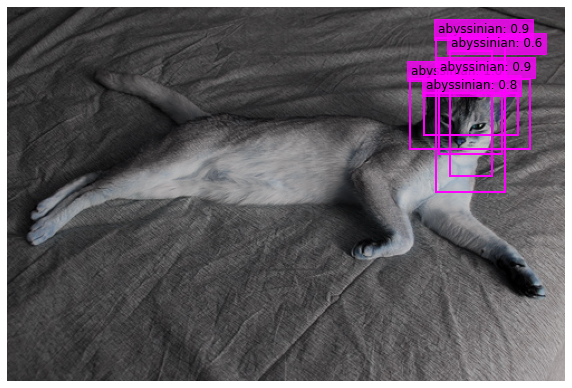

In [52]:
# Inference on User Images
object_detection_api(model, device=device, threshold=0.5)